## Setup

In [1]:
# Necessary imports

from datetime import datetime, timedelta
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.stats import iqr
import shutil
import zipfile
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from pathlib import Path

%matplotlib inline

In [ ]:
start_time = datetime.now()

In [3]:
# Download data from OpenNeuro ⏳

!openneuro-py download --dataset ds005090 --target_dir data-phantom/


👋 Hello! This is openneuro-py 2023.1.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds005025 …
GraphQL query failed with 1 errors
Traceback (most recent call last):
  File "/Users/evaalonsoortiz/opt/miniconda3/lib/python3.9/site-packages/openneuro/_download.py", line 228, in _get_download_metadata
    get_token()
  File "/Users/evaalonsoortiz/opt/miniconda3/lib/python3.9/site-packages/openneuro/config.py", line 69, in get_token
    raise ValueError(
ValueError: Could not read API token as no openneuro-py configuration file exists. Run "openneuro login" to generate it.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/evaalonsoortiz/opt/miniconda3/bin/openneuro-py", line 8, in <module>
    sys.exit(cli())
  File "/Users/evaalonsoortiz/opt/miniconda3/lib/python3.9/site-packages/click/core.py", line 1130, in __call_

In [2]:
# Define useful variables
path_data = os.path.join(os.getcwd(), "data-phantom/")
print(f"path_data: {path_data}")
path_labels = os.path.join(path_data, "derivatives", "labels")
path_qc = os.path.join(path_data, "qc")
subjects = [os.path.basename(subject_path) for subject_path in sorted(glob.glob(os.path.join(path_data, "sub-*")))]
print(f"subjects: {subjects}")

# Create output folder
path_results = os.path.join(path_data, "derivatives", "results")
os.makedirs(path_results, exist_ok=True)

path_data: /Users/evaalonsoortiz/Documents/Academic/Postdoc_NeuroPoly/Projects/THS_7T/coil-qc-code/data-phantom/
subjects: ['sub-CRMBM', 'sub-MGH', 'sub-MNI', 'sub-MPI', 'sub-MSSM', 'sub-NTNU', 'sub-UCL']


## Convert TFL and DREAM flip angle maps to B1+ in units of nT/V 

In [3]:
# load DREAM FA maps acquired with different reference voltages
# threshold FA maps to 20deg < FA < 50deg
# combine FA maps by averaging non-zero estimates of FA in each pixel

GAMMA = 2.675e8;  # [rad / (s T)]
voltages = ["1.5", "0.66"]

for subject in subjects:
    
    b1_maps = []
    os.chdir(os.path.join(path_data, subject, "fmap"))

    if subject=='sub-MSSM1':
        ref_voltage=450
    elif subject=='sub-MSSM2':
        ref_voltage=350
    elif subject=='sub-MSSM3':
        ref_voltage=450
    else:     
        # Fetch the reference voltage from the JSON sidecar 
        with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
            metadata = json.load(f)
            ref_voltage = metadata.get("TxRefAmp", "N/A")
            if (ref_voltage == "N/A"):
                ref_token = "N/A"
                for token in metadata.get("SeriesDescription", "N/A").split("_"):
                    if token.startswith("RefV"): ref_token = token
                ref_voltage = float(ref_token[4:-1])
    
    # Open refV flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1DREAM.nii.gz")
    meas_fa = nii.get_fdata()
    #thresholding
    meas_fa[meas_fa < 200] = np.nan
    meas_fa[meas_fa > 500] = np.nan

    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
        meas_fa = (meas_fa/10) / requested_fa

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095
    # Compute B1 map in [T/V]
    b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
    # Convert to [nT/V]
    b1_map = b1_map * 1e9
    
    b1_maps.append(b1_map)

    for voltage in voltages:
        
        #check if map exists
        my_file = Path(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
        
        if my_file.is_file():
            
            if subject=='sub-MSSM2' and voltage=="1.5":
                ref_voltage=450
            elif subject=='sub-MSSM2' and voltage=="0.66":
                ref_voltage=234
            elif subject=='sub-MSSM3' and voltage=="0.66":
                ref_voltage=328
            else:            
                # Fetch the reference voltage from the JSON sidecar 
                with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                    metadata = json.load(f)
                    ref_voltage = metadata.get("TxRefAmp", "N/A")
                    if (ref_voltage == "N/A"):
                        ref_token = "N/A"
                        for token in metadata.get("SeriesDescription", "N/A").split("_"):
                            if token.startswith("RefV"): ref_token = token
                        ref_voltage = float(ref_token[4:-1])
                
            # Open flip angle map with nibabel
            nii = nib.load(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
            meas_fa = nii.get_fdata()
            #thresholding
            meas_fa[meas_fa < 200] = np.nan
            meas_fa[meas_fa > 500] = np.nan
        
            # Fetch the flip angle from the JSON sidecar 
            with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                metadata = json.load(f)
                requested_fa = metadata.get("FlipAngle", "N/A")
                #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
                meas_fa = (meas_fa/10) / requested_fa
        else:
            meas_fa = np.full((nii.header).get_data_shape(),np.nan)

        # Account for the power loss between the coil and the socket. That number was given by Siemens.
        voltage_at_socket = ref_voltage * 10 ** -0.095
        # Compute B1 map in [T/V]
        # Siemens maps are in units of flip angle * 10 (in degrees)
        b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
        # Convert to [nT/V]
        b1_map = b1_map * 1e9
        
        b1_maps.append(b1_map)
 
    # compute mean of non-zero values
    avgB1=np.nanmean(b1_maps,axis=0)
    
    # Save as NIfTI file
    nii_avgB1 = nib.Nifti1Image(avgB1, nii.affine, nii.header)
    nib.save(nii_avgB1, f"{subject}_DREAMTB1avgB1map.nii.gz")
    

/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/4246477433.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/4246477433.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/4246477433.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/4246477433.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/4246477433.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/4246477433.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/s5/9kk838_10bl825z692jjscs80000gn/T/ipykernel_41344/42464

In [4]:
# Convert the TFL flip angle maps to B1+ efficiency maps [nT/V] (inspired by code from Kyle Gilbert)
# The approach consists in calculating the B1+ efficiency using a 1ms, pi-pulse at the acquisition voltage,
# then scale the efficiency by the ratio of the measured flip angle to the requested flip angle in the pulse sequence.

GAMMA = 2.675e8;  # [rad / (s T)]

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))

    if subject=='sub-MSSM1':
        ref_voltage=450
    elif subject=='sub-MSSM2':
        ref_voltage=350
    elif subject=='sub-MSSM3':
        ref_voltage=450
    else:     
        # Fetch the reference voltage from the JSON sidecar 
        with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
            metadata = json.load(f)
            ref_voltage = metadata.get("TxRefAmp", "N/A")
            if (ref_voltage == "N/A"):
                ref_token = "N/A"
                for token in metadata.get("SeriesDescription", "N/A").split("_"):
                    if token.startswith("RefV"): ref_token = token
                ref_voltage = float(ref_token[4:-1])
        
    print(f"ref_voltage [V]: {ref_voltage} ({subject}_acq-famp_TB1TFL)")
                
    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        print(f"flip angle [degrees]: {requested_fa} ({subject}_acq-famp_TB1TFL)")

    # Open flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1TFL.nii.gz")
    meas_fa = nii.get_fdata()

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095

    # Compute B1 map in [T/V]
    # Siemens maps are in units of flip angle * 10 (in degrees)
    b1_map = ((meas_fa / 10) / requested_fa) * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))

    # Convert to [nT/V]
    b1_map = b1_map * 1e9

    # Save B1 map in [T/V] as NIfTI file
    nii_b1 = nib.Nifti1Image(b1_map, nii.affine, nii.header)
    nib.save(nii_b1, f"{subject}_TFLTB1map.nii.gz")


ref_voltage [V]: 224.5 (sub-CRMBM_acq-famp_TB1TFL)
flip angle [degrees]: 90 (sub-CRMBM_acq-famp_TB1TFL)
ref_voltage [V]: 419.5 (sub-MGH_acq-famp_TB1TFL)
flip angle [degrees]: 89.99 (sub-MGH_acq-famp_TB1TFL)
ref_voltage [V]: 464 (sub-MNI_acq-famp_TB1TFL)
flip angle [degrees]: 89.99 (sub-MNI_acq-famp_TB1TFL)
ref_voltage [V]: 408 (sub-MPI_acq-famp_TB1TFL)
flip angle [degrees]: 90 (sub-MPI_acq-famp_TB1TFL)
ref_voltage [V]: 422 (sub-MSSM_acq-famp_TB1TFL)
flip angle [degrees]: 68 (sub-MSSM_acq-famp_TB1TFL)
ref_voltage [V]: 408 (sub-NTNU_acq-famp_TB1TFL)
flip angle [degrees]: 90 (sub-NTNU_acq-famp_TB1TFL)
ref_voltage [V]: 270 (sub-UCL_acq-famp_TB1TFL)
flip angle [degrees]: 90 (sub-UCL_acq-famp_TB1TFL)


## Load data and generate figures 

In [ ]:
##############################################################################################
# generate figures for B1+ and SNR maps 
##############################################################################################

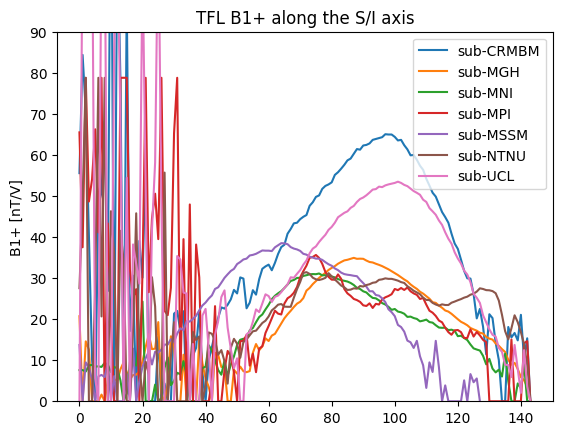

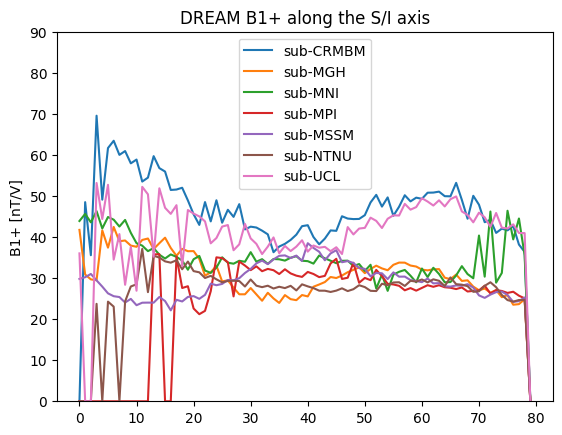


--
Spinal Cord Toolbox (6.2)

sct_image -i sub-CRMBM_acq-coilQaSagLarge_SNR.nii.gz -split t -o sub-CRMBM_acq-coilQaSagLarge_SNR.nii.gz
--

Generate output files...

Done! To view results, type:
fsleyes sub-CRMBM_acq-coilQaSagLarge_SNR_T0000.nii.gz sub-CRMBM_acq-coilQaSagLarge_SNR_T0001.nii.gz sub-CRMBM_acq-coilQaSagLarge_SNR_T0002.nii.gz sub-CRMBM_acq-coilQaSagLarge_SNR_T0003.nii.gz sub-CRMBM_acq-coilQaSagLarge_SNR_T0004.nii.gz sub-CRMBM_acq-coilQaSagLarge_SNR_T0005.nii.gz &


--
Spinal Cord Toolbox (6.2)

sct_image -i sub-MGH_acq-coilQaSagLarge_SNR.nii.gz -split t -o sub-MGH_acq-coilQaSagLarge_SNR.nii.gz
--

Generate output files...

Done! To view results, type:
fsleyes sub-MGH_acq-coilQaSagLarge_SNR_T0000.nii.gz sub-MGH_acq-coilQaSagLarge_SNR_T0001.nii.gz sub-MGH_acq-coilQaSagLarge_SNR_T0002.nii.gz sub-MGH_acq-coilQaSagLarge_SNR_T0003.nii.gz sub-MGH_acq-coilQaSagLarge_SNR_T0004.nii.gz sub-MGH_acq-coilQaSagLarge_SNR_T0005.nii.gz &


--
Spinal Cord Toolbox (6.2)

sct_image -i sub-MNI_

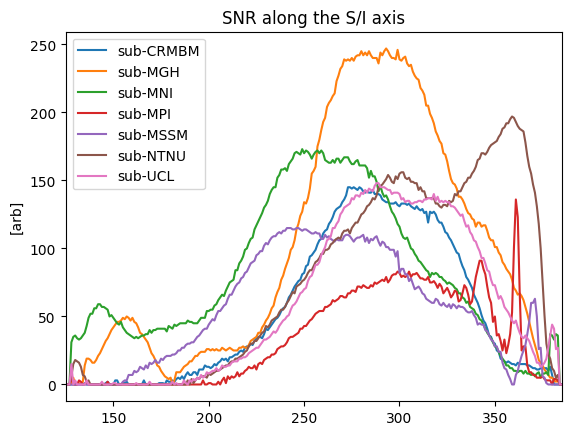

In [5]:
# figure types
fig_types = ["TFL B1+ along the S/I axis", "DREAM B1+ along the S/I axis","SNR along the S/I axis"]
file_names = ["TFLTB1map", "DREAMTB1avgB1map","acq-coilQaSagLarge_SNR_T0000"]

for fig_type, file_name in zip(fig_types, file_names):

    fig=plt.plot()

    for subject in subjects:
        
        os.chdir(os.path.join(path_data, f"{subject}", "fmap"))

        if file_name=="acq-coilQaSagLarge_SNR_T0000":
            # Splitting SNR map 
            !sct_image -i {subject}_acq-coilQaSagLarge_SNR.nii.gz -split t -o {subject}_acq-coilQaSagLarge_SNR.nii.gz
    
        # Load data
        map=nib.load(f"{subject}_{file_name}.nii.gz")

        if file_name=="acq-coilQaSagLarge_SNR_T0000":
            data=map.get_fdata()[round(map.get_fdata().shape[0]/2),125:385,round(map.get_fdata().shape[2]/2)]
            
        data=map.get_fdata()[round(map.get_fdata().shape[0]/2),:,round(map.get_fdata().shape[2]/2)]
        #data = data[np.nonzero(data)] 
    
        plt.plot(data,label=subject)

    plt.legend()
    plt.title(fig_type)
    
    if file_name=="acq-coilQaSagLarge_SNR_T0000":
        plt.ylabel("[arb]")
        plt.xlim(125, 385)
    else:
        plt.ylim(0, 90)
        plt.ylabel("B1+ [nT/V]")
    plt.show()
    


In [ ]:
###########################################################################################################
# generate figures for B1+, SNR, and 1/g-factor maps obtained at each site 
###########################################################################################################

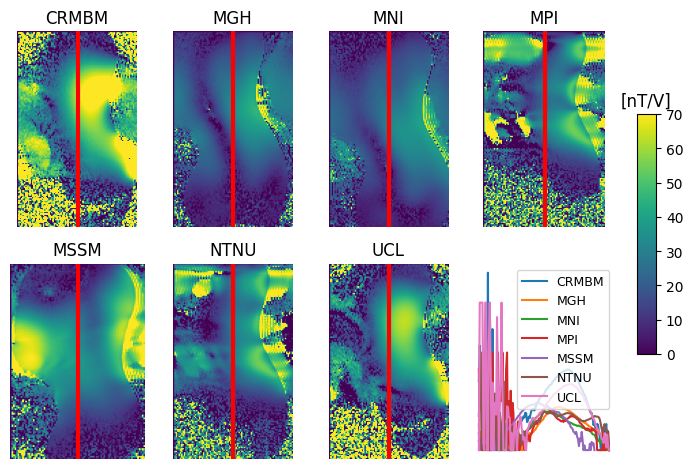

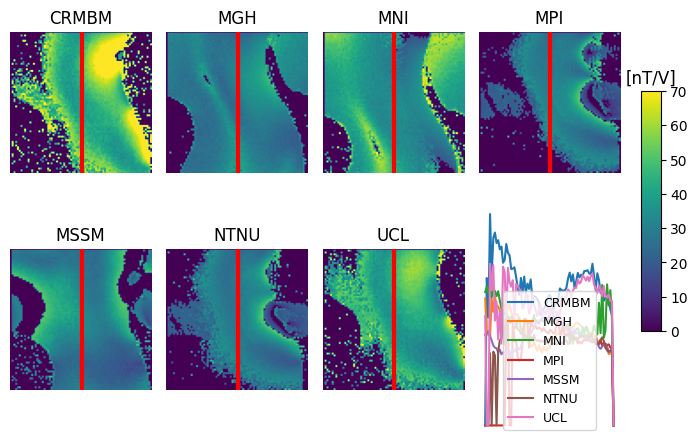

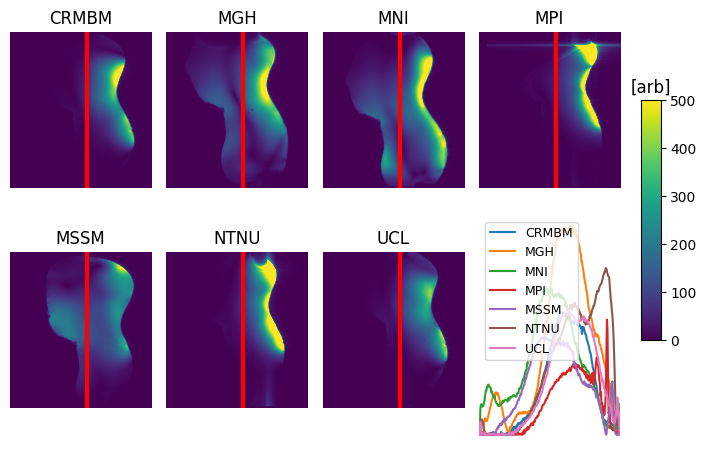

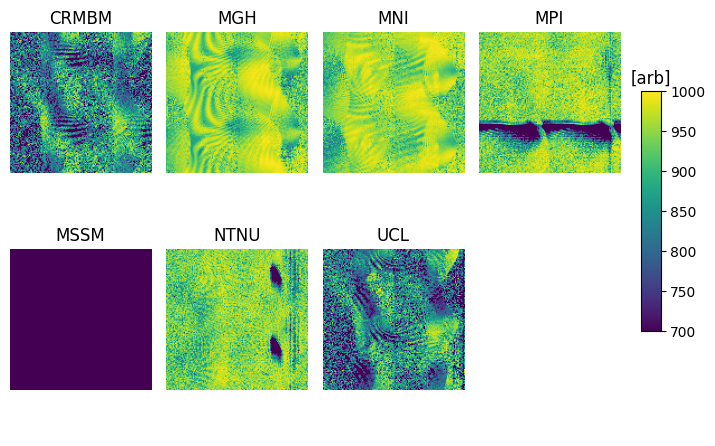

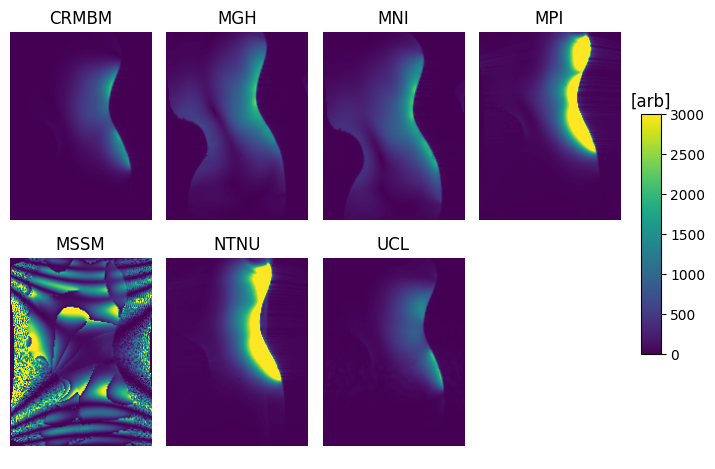

In [8]:
sites = ["CRMBM", "MGH", "MNI", "MPI", "MSSM", "NTNU", "UCL"]

# map types
map_types = ["TFLTB1map", "DREAMTB1avgB1map", "acq-coilQaSagLarge_SNR_T0000", "acq-coilQaSagSmall_GFactor", "T2starw"]

# legend types
legend_types = ["[nT/V]", "[nT/V]", "[arb]", "[arb]", "[arb]"]


for map_type, legend_type in zip(map_types,legend_types):
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 4)#, figsize=(10, 8))
    font_size = 12
    axes=axes.flatten() 
        
    for i,site in enumerate(sites):
        # Load data
        if map_type=="T2starw":
            os.chdir(os.path.join(path_data, f"sub-{site}", "anat"))
        else:         
            os.chdir(os.path.join(path_data, f"sub-{site}", "fmap"))
        
        map=nib.load(f"sub-{site}_{map_type}.nii.gz")
        
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            data=map.get_fdata()[115:350,125:385,round(map.get_fdata().shape[2]/2)]
        elif map_type=="acq-coilQaSagSmall_GFactor":
            data=map.get_fdata()[64:191,64:191,round(map.get_fdata().shape[2]/2),5]
        else:
            data=map.get_fdata()[:,:,round(map.get_fdata().shape[2]/2)]
    
        # Plot
        axes[-1].axis('off')
            
        dynmin = 0 
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            dynmax = 500
        elif map_type=="acq-coilQaSagSmall_GFactor":
            dynmin = 700
            dynmax = 1000
            axes[-1].axis('off')
        elif map_type=="T2starw":
            dynmax = 3000
            axes[-1].axis('off')
        else:
            dynmax = 70    
            
        splot=axes[i]
        im = splot.imshow((data.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax)

        if (map_type == "TFLTB1map" or map_type == "DREAMTB1avgB1map"):
            splot.axvline(map.get_fdata().shape[0]/2,linewidth=3,color ='red')
        elif map_type == "acq-coilQaSagLarge_SNR_T0000":
            splot.axvline(map.get_fdata().shape[0]/4,linewidth=3,color ='red')
        
        splot.set_title(site, size=font_size)
        splot.axis('off')

    if (map_type == "TFLTB1map" or map_type == "DREAMTB1avgB1map" or map_type == "acq-coilQaSagLarge_SNR_T0000"):
        
        for site in sites:
        
            os.chdir(os.path.join(path_data, f"sub-{site}", "fmap"))
            # Load data
            map=nib.load(f"sub-{site}_{map_type}.nii.gz")

            if file_name=="acq-coilQaSagLarge_SNR_T0000":
                data=map.get_fdata()[round(map.get_fdata().shape[0]/4),125:385,round(map.get_fdata().shape[2]/2)]
            else:
                data=map.get_fdata()[round(map.get_fdata().shape[0]/2),:,round(map.get_fdata().shape[2]/2)]
            
            data=map.get_fdata()[round(map.get_fdata().shape[0]/2),:,round(map.get_fdata().shape[2]/2)]
            axes[-1].plot(data,label=site)
            
        axes[-1].legend(fontsize=9)
    
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            axes[-1].set_xlim(125, 385)
            axes[-1].set_ylabel("[arb]")
        else:
            axes[-1].set_ylabel("B1+ [nT/V]")

        axes[-1].yaxis.set_label_position("right")
        axes[-1].yaxis.tick_right()
    
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.1, hspace=0.1, right=0.9)

    # Colorbar
    # Assume that the colorbar should start at the bottom of the lower row of subplots and
    # extend to the top of the upper row of subplots
    cbar_bottom = 0.25  # This might need adjustment
    cbar_height = 0.5  # This represents the total height of both rows of subplots
    if (map_type == "TFLTB1map" or map_type == "DREAMTB1avgB1map" or map_type == "acq-coilQaSagLarge_SNR_T0000") and ind_subject == '4':
        cbar_dist = 0.99
    else:
        cbar_dist = 1.01
    cbar_ax = fig.add_axes([cbar_dist, cbar_bottom, 0.03, cbar_height])
    cbar = plt.colorbar(im, cax=cbar_ax)

    cbar_ax.set_title(legend_type, size=12)
    plt.show()


In [ ]:
###########################################################################################################
# generate tiled figure with individual channel GRE maps 
###########################################################################################################

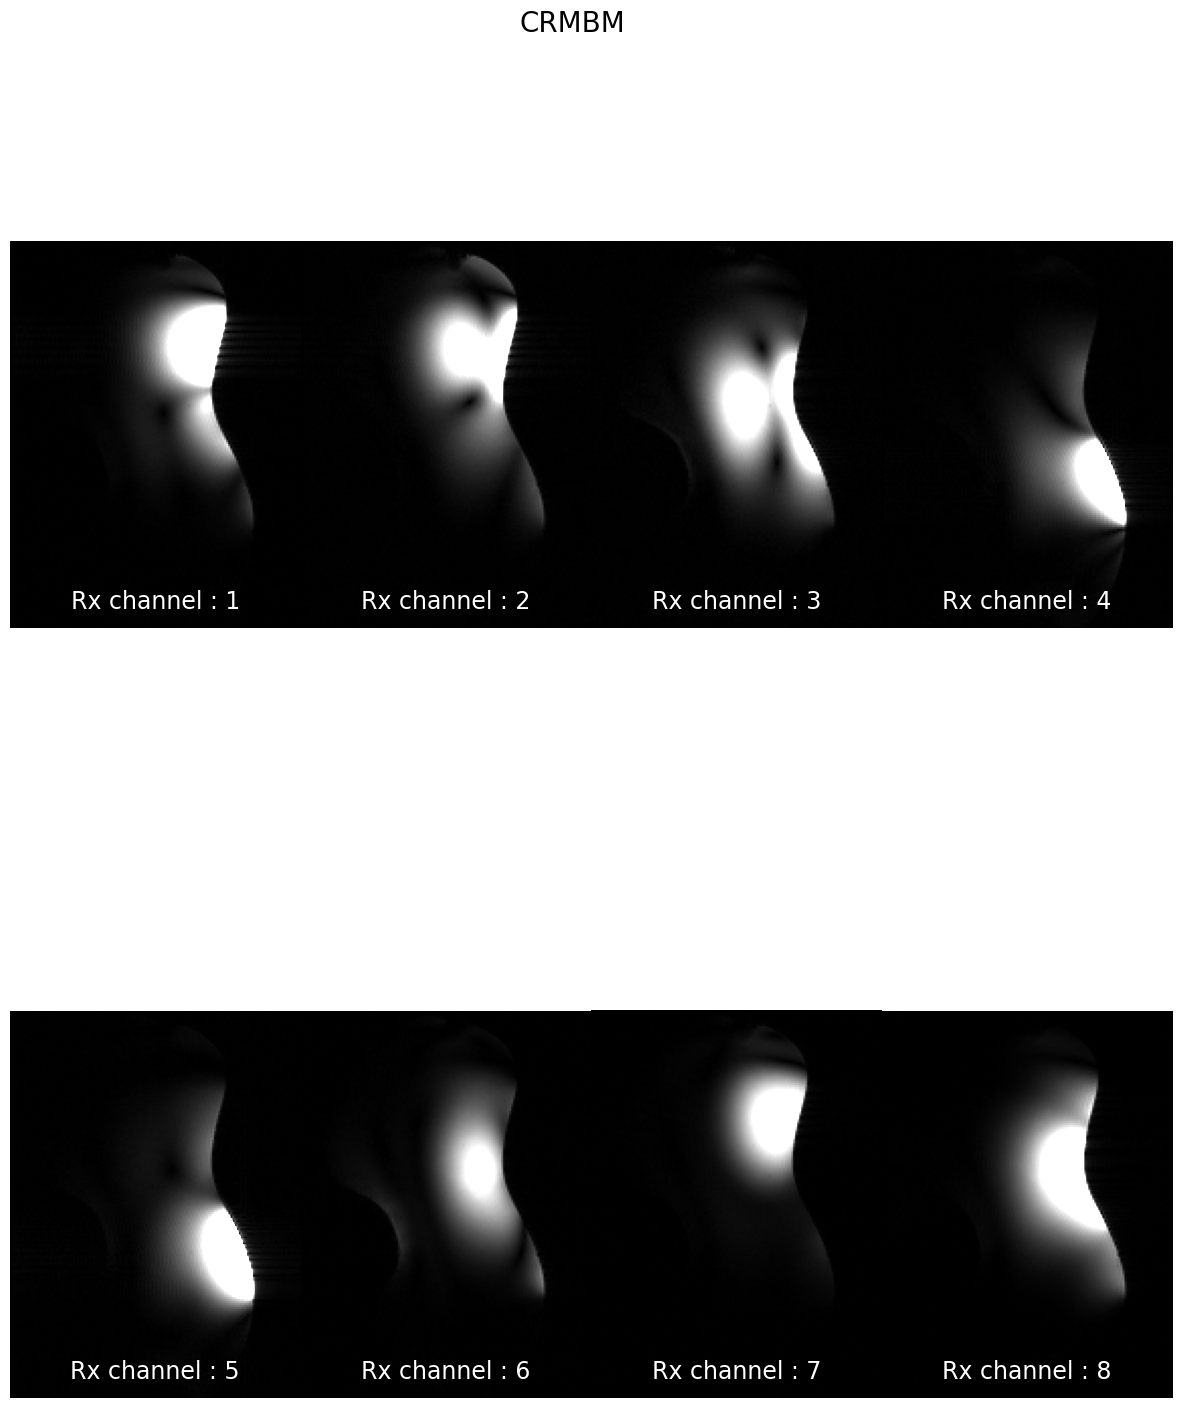

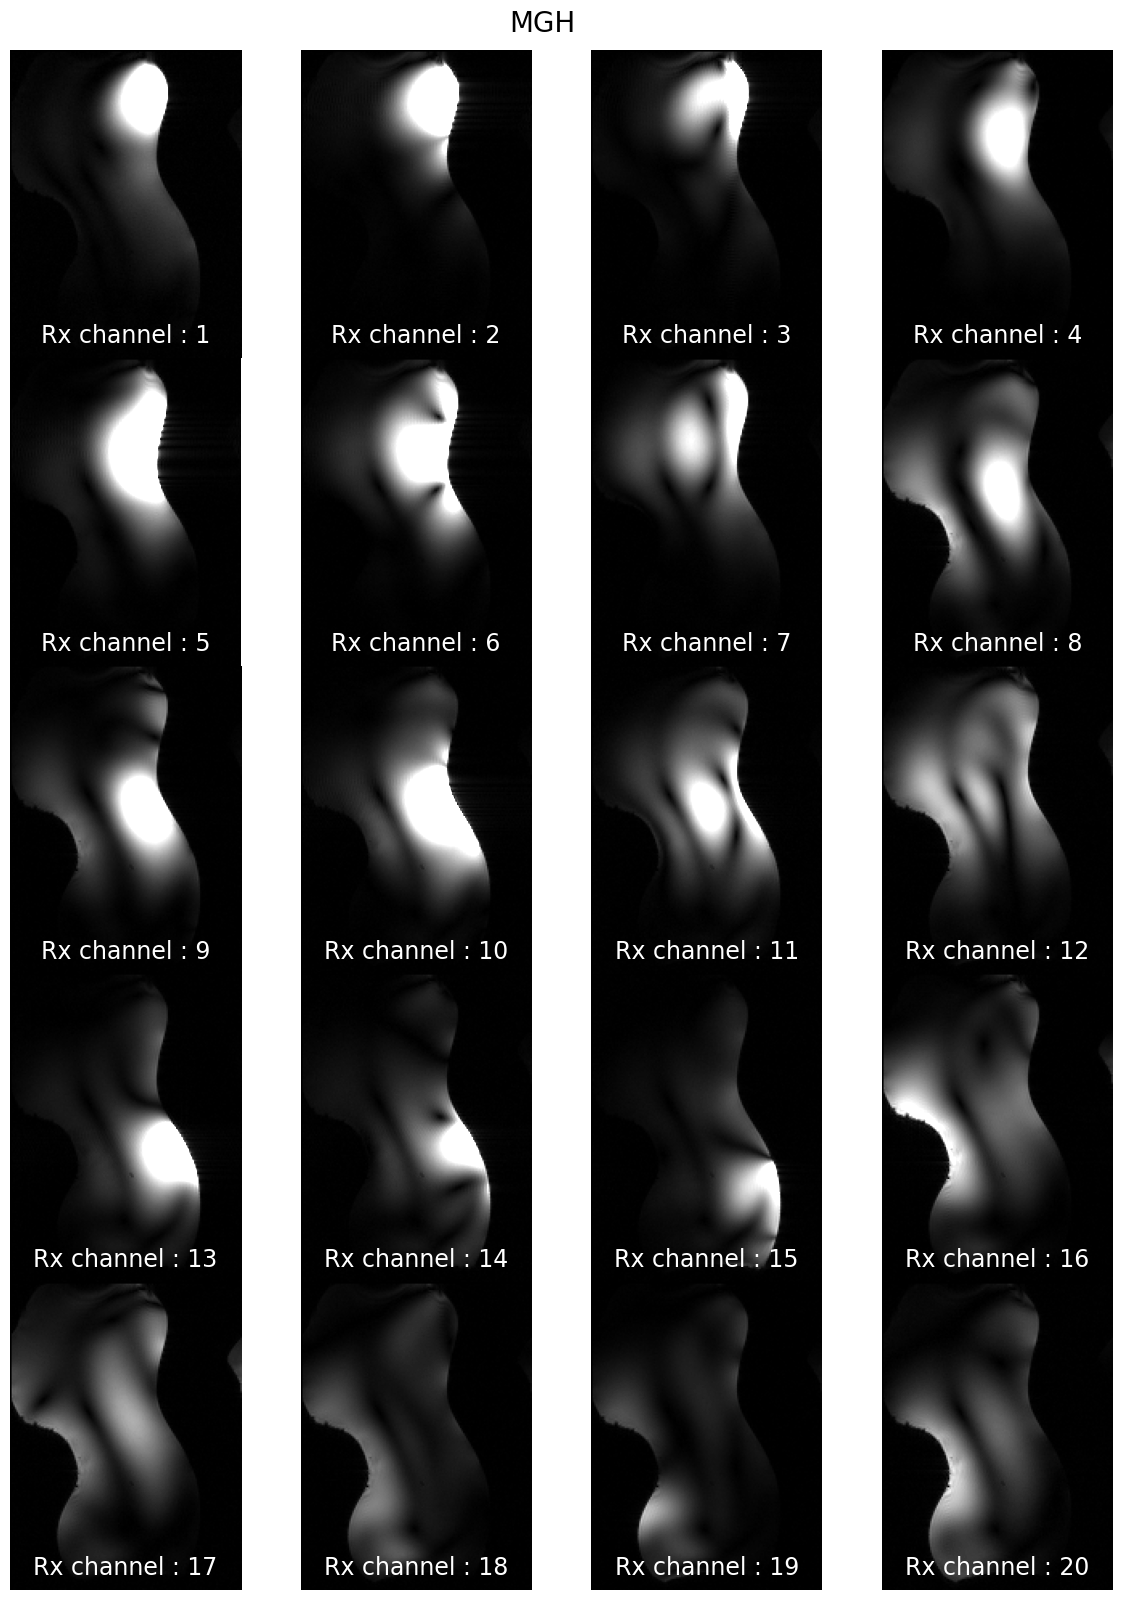

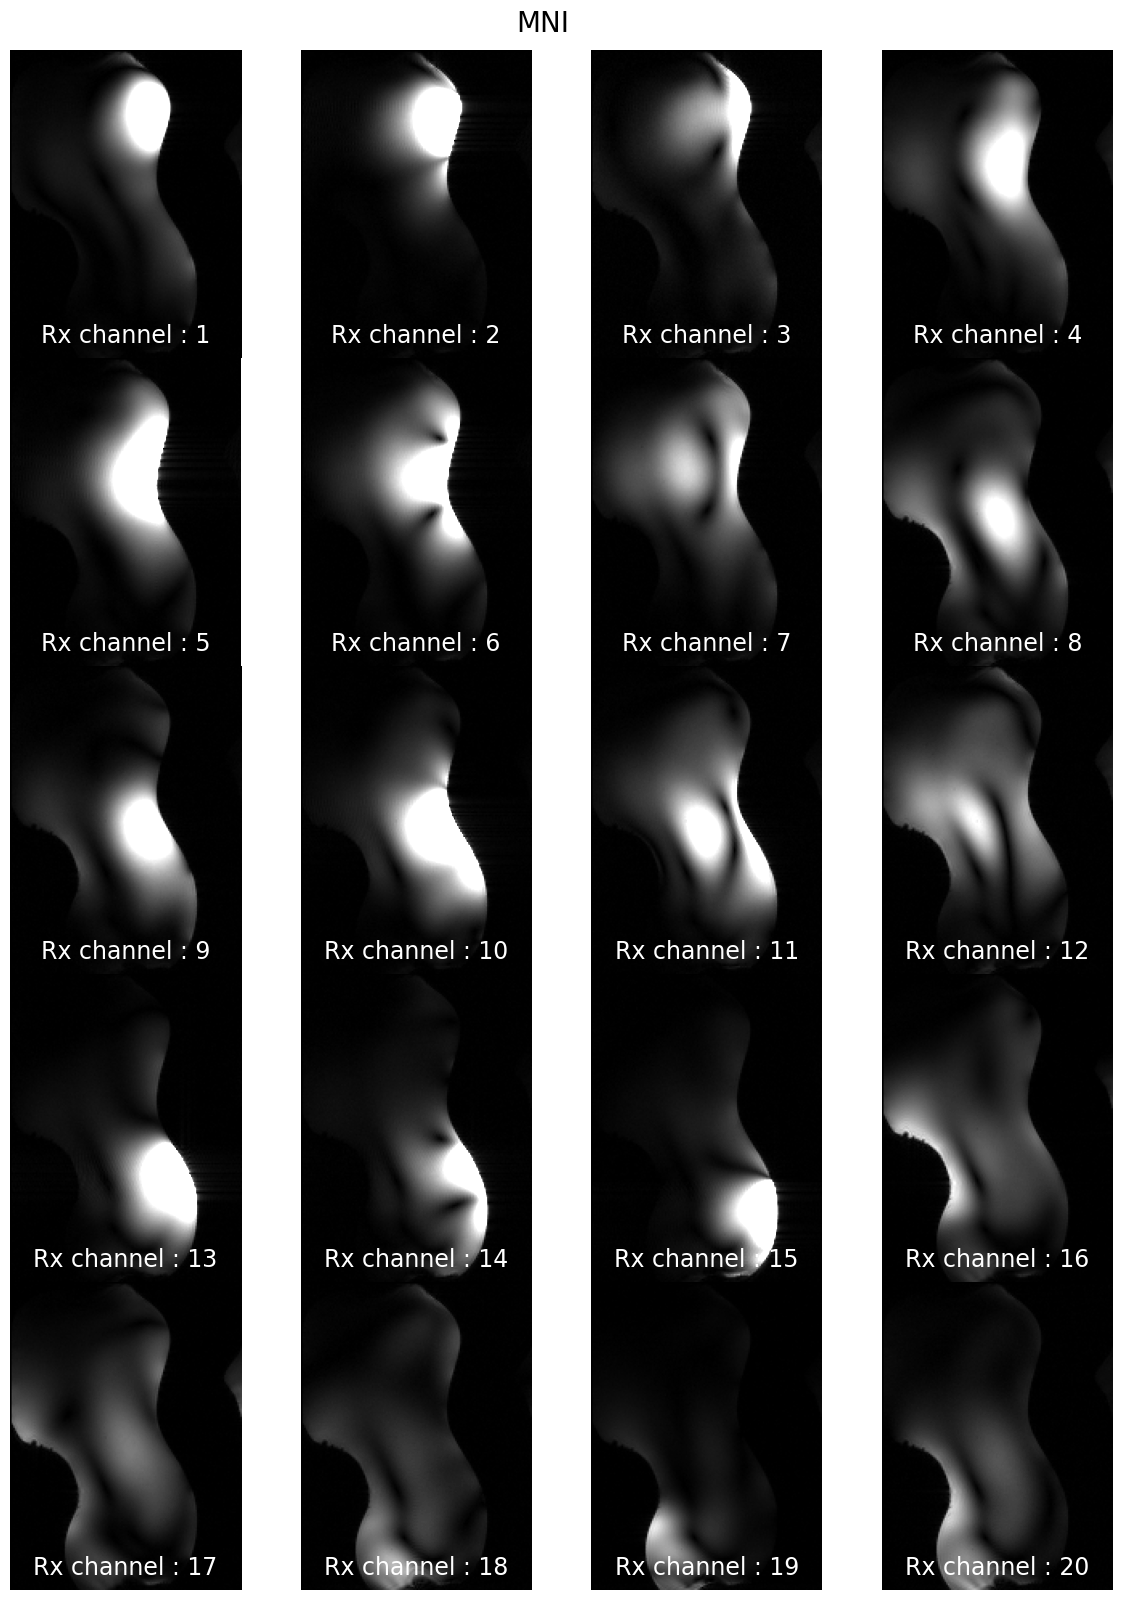

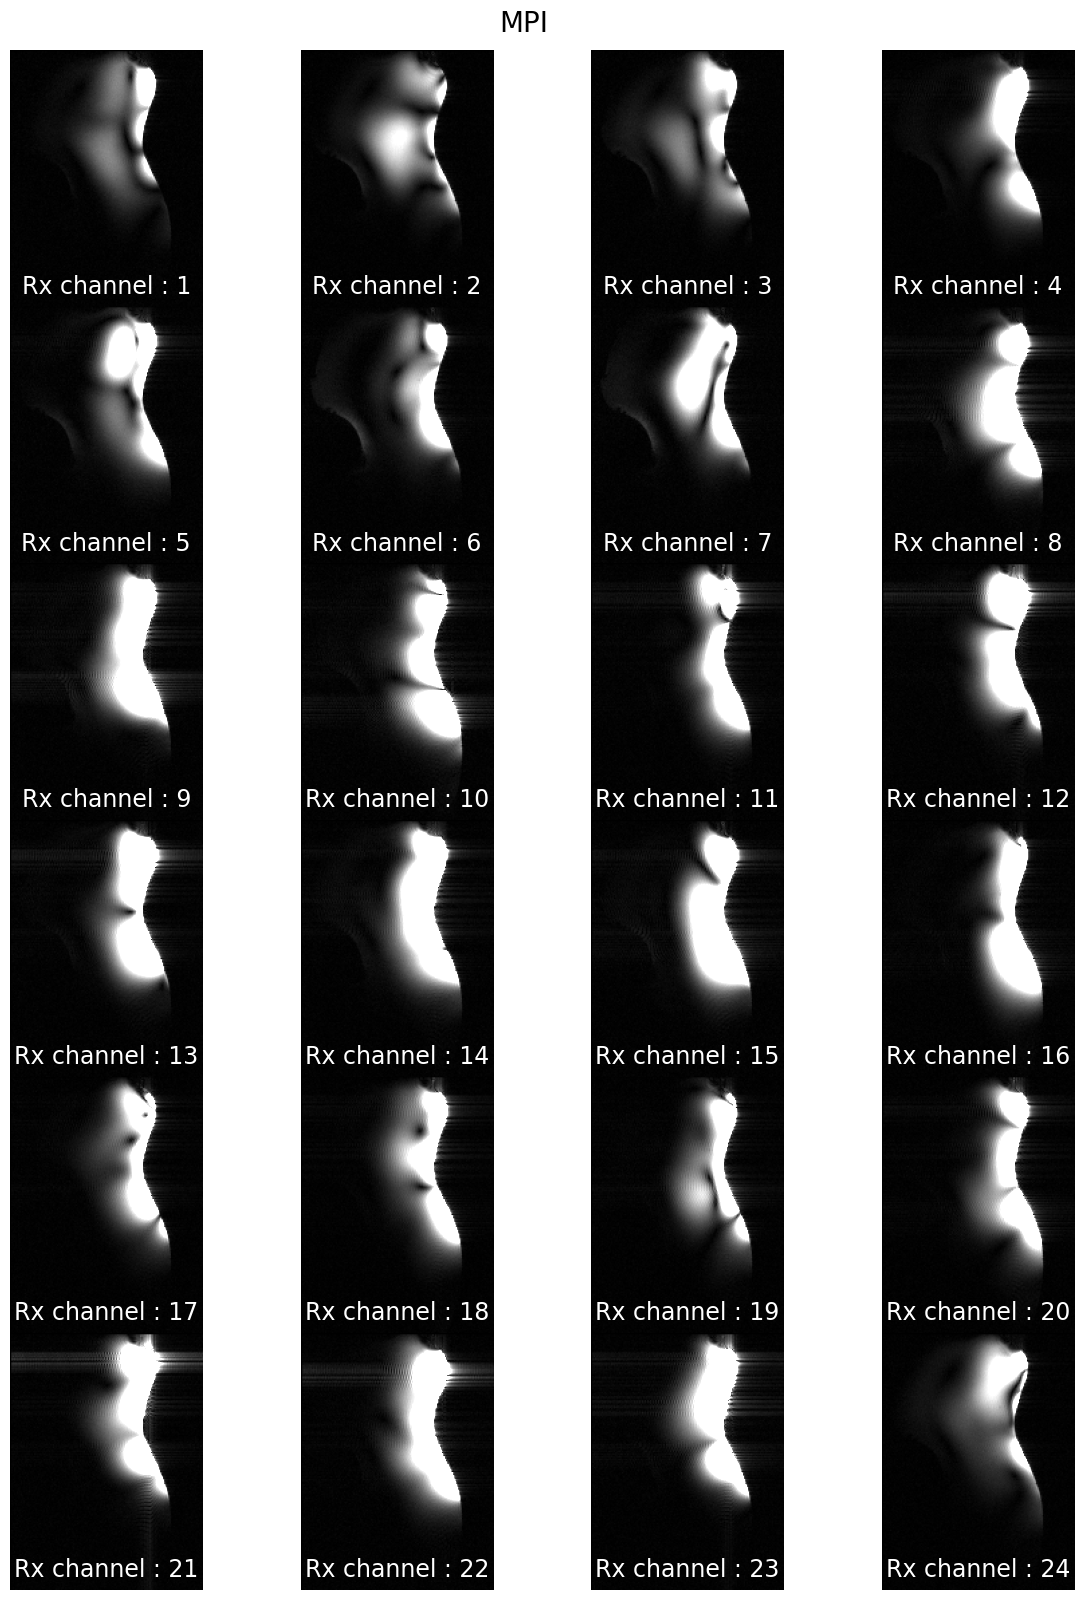

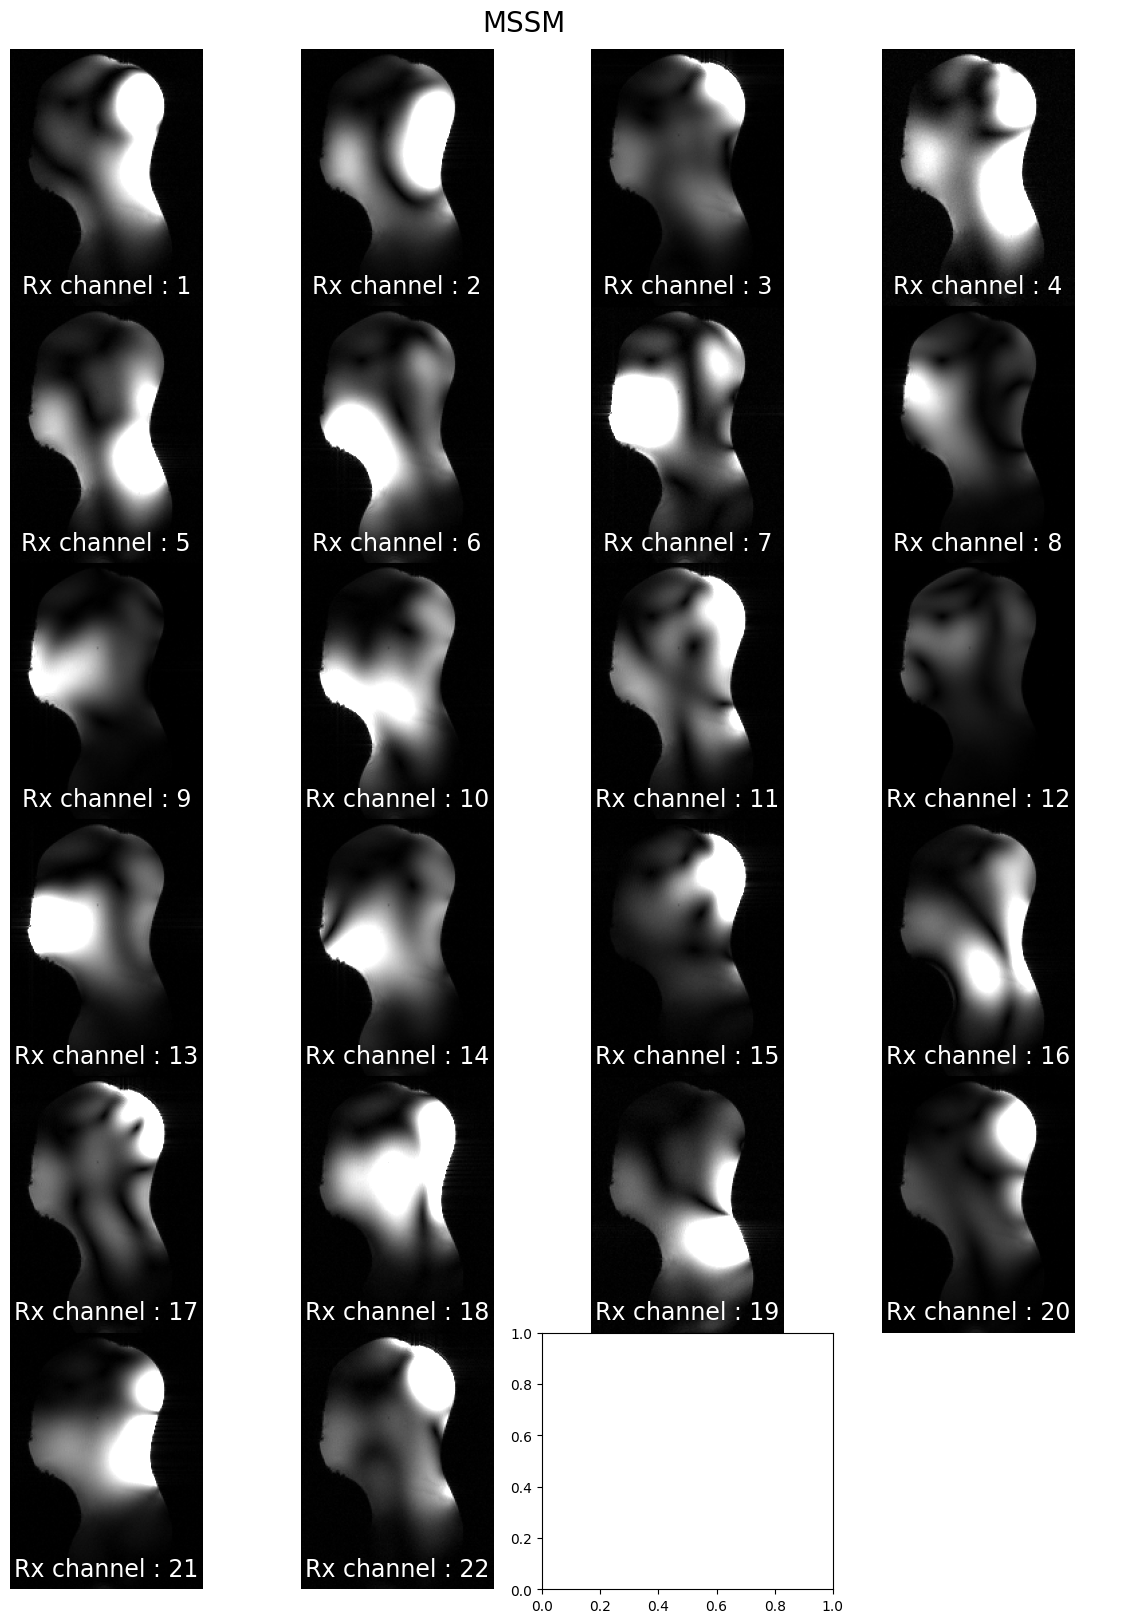

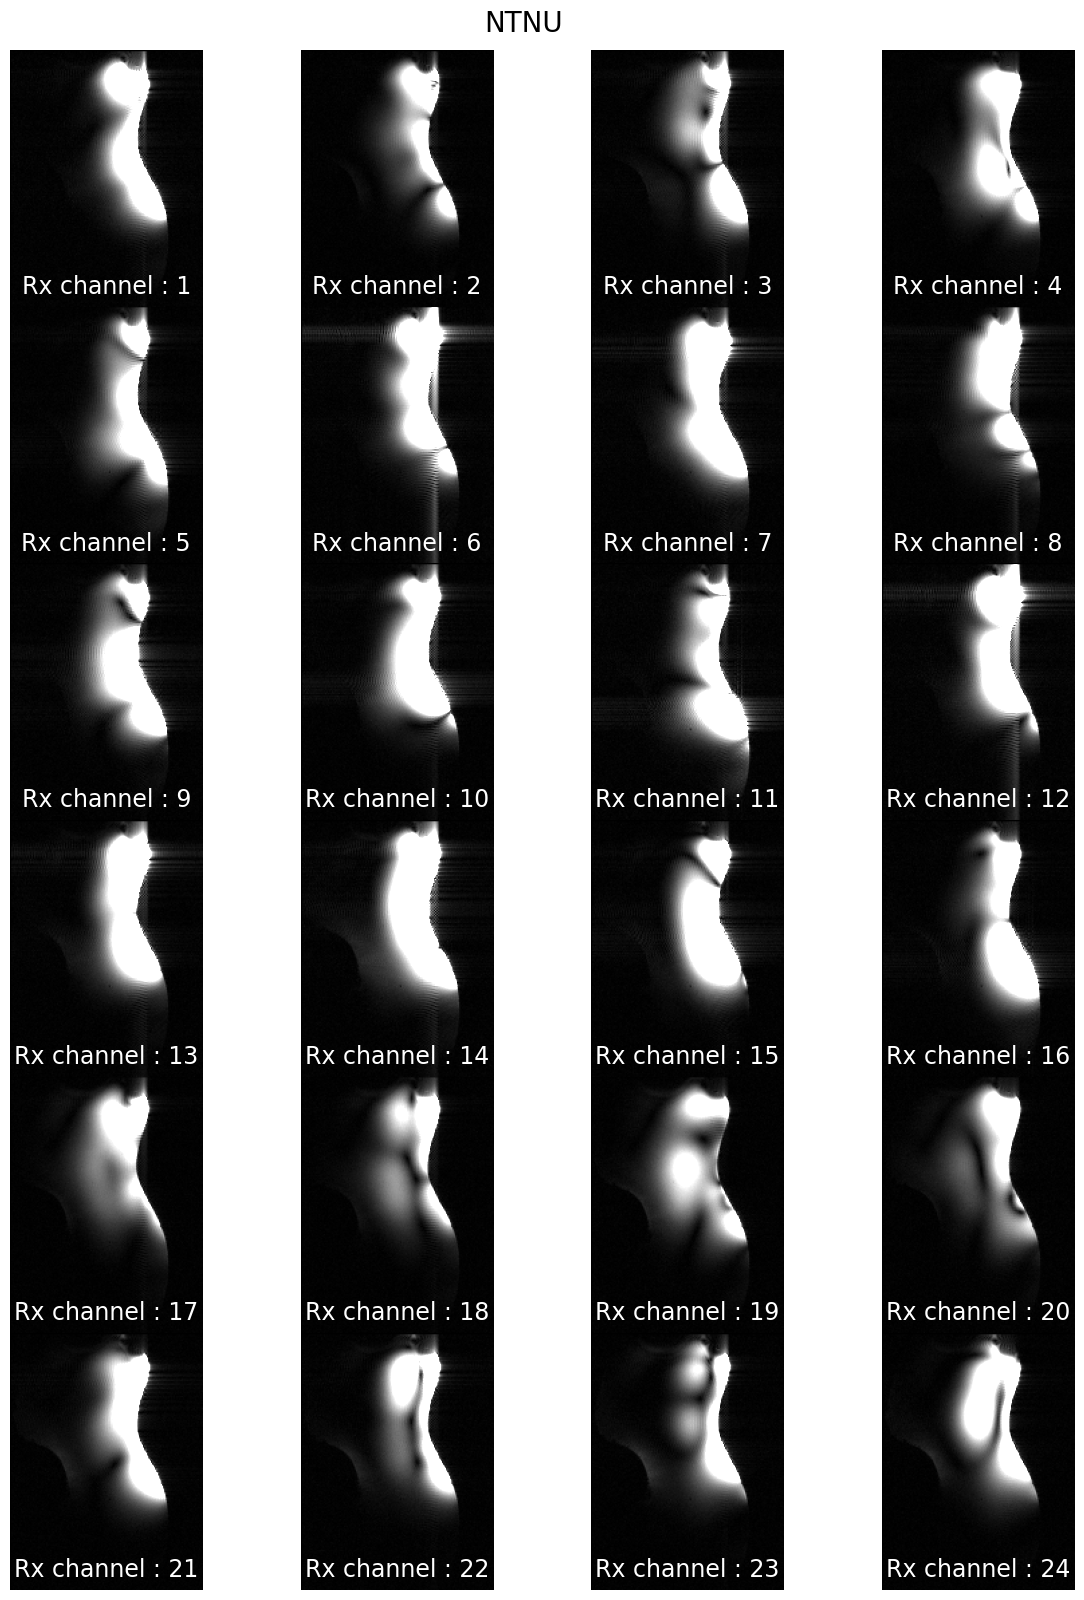

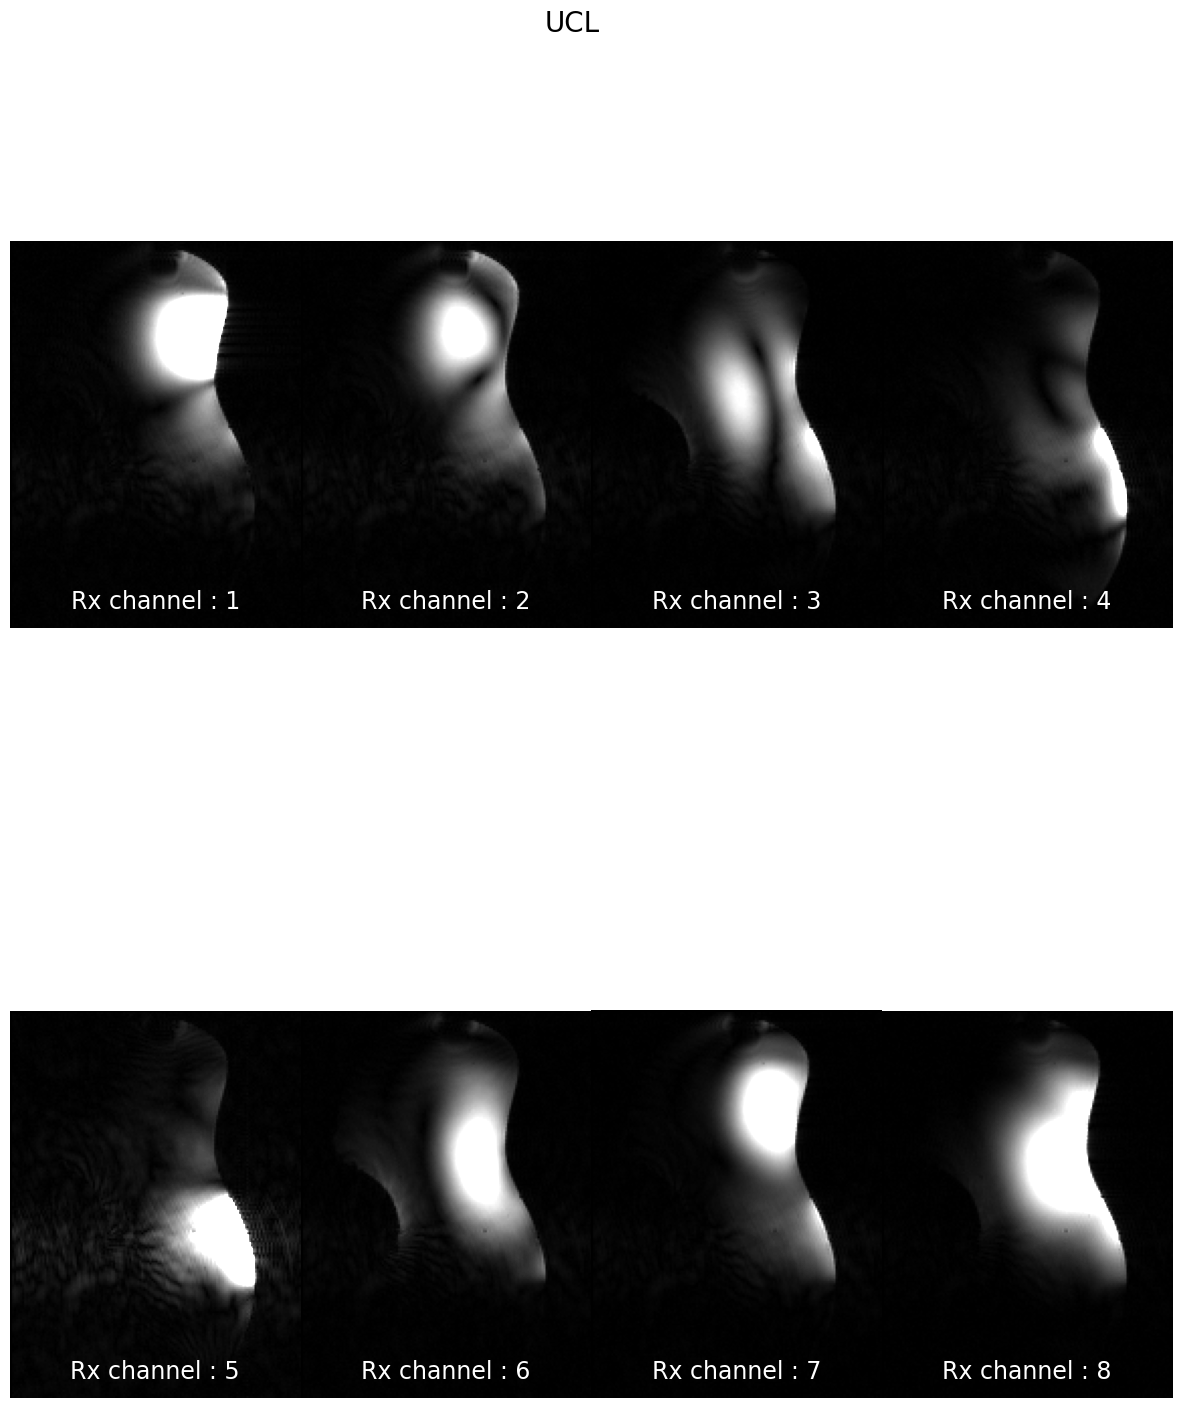

In [9]:
sites = ["CRMBM", "MGH", "MNI", "MPI", "MSSM", "NTNU", "UCL"]
        
for i,site in enumerate(sites):

    gre_files=sorted(glob.glob(os.path.join(path_data, f"sub-{site}", "anat", '*uncombined*.nii.gz')))
        
    #Tiled figure in a five-row layout
    rows=int(np.ceil(len(gre_files)/4))
    cols=int(np.ceil(len(gre_files)/rows))

    fig=plt.figure(figsize=(15, 20))
    
    ax = fig.subplots(rows,cols,squeeze=True)
    
    for row in range(rows):
        for col in range(cols):

            i = row*cols+col

            if i < len(gre_files):
            
                #read in files
                data_to_plot=(nib.load(gre_files[i])).get_fdata() #load in nifti object, get only image data
                data_to_plot=np.rot90(data_to_plot[:,:,int(np.floor(data_to_plot.shape[2]/2))]) #central slice
           
                ax[row,col].imshow(data_to_plot,cmap=plt.cm.gray,clim=[0, 300])
                ax[row,col].text(0.5, 0.05, 'Rx channel : ' + str(i+1),horizontalalignment='center', transform=ax[row,col].transAxes,color='white',fontsize=17)
                ax[row,col].axis('off')

    plt.axis('off')
    plt.subplots_adjust(hspace=0,wspace=0)
    fig.suptitle(site, fontsize=20, y=0.9)


## Finished

In [ ]:
# Indicate duration of data processing

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

# Convert seconds to a timedelta object
total_time_delta = timedelta(seconds=total_time)

# Format the timedelta object to a string
formatted_time = str(total_time_delta)

# Pad the string representation if less than an hour
formatted_time = formatted_time.rjust(8, '0')

print(f"Total Runtime [hour:min:sec]: {formatted_time}")